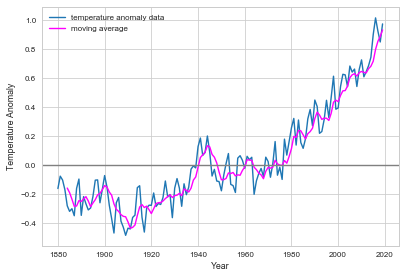

In [22]:
import pandas as pd
import numpy as np

gistemp_data = pd.read_csv('https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv').reset_index()

#cols: DJF (winter), MAM (spring), JJA (summer) and SON (autumn) 
gistemp_data = gistemp_data.reset_index().rename(columns = gistemp_data.iloc[0]).iloc[1:, 1:]

def make_na(cell):
    if cell == '***':
        return np.nan
    return cell

gistemp_data = gistemp_data.applymap(lambda x: float(make_na(x)))
gistemp_data['avg'] = gistemp_data.iloc[:,1:13].apply(np.mean, axis = 1)
rolling_mean = gistemp_data.avg.rolling(window=5).mean()

import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
plt.plot(gistemp_data.Year, gistemp_data.avg, label = 'temperature anomaly data')
plt.plot(gistemp_data.Year, rolling_mean, color = 'magenta', label = 'moving average')
plt.axhline(y = 0, color = 'gray')
plt.ylabel('Temperature Anomaly')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.savefig('/Users/eddieshiang/climate_boot/pic1.png', dpi= 300)
plt.show()


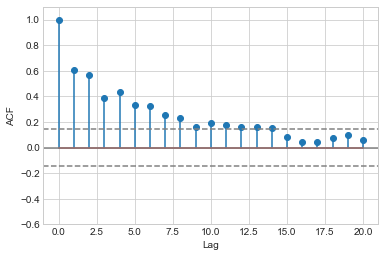

In [2]:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
all_changes = gistemp_data[(gistemp_data['Year'] >= 1998) & \
              (gistemp_data['Year'] <= 2013)].iloc[:, 1:13] 
monthly_df = pd.DataFrame(pd.Series(all_changes.values.ravel()), columns = ['change'])

lags = 20
acf_vals = sm.tsa.acf(monthly_df, nlags = lags)
plt.ylim(-0.6, 1.1)
plt.stem(list(range(lags + 1)), acf_vals)
plt.axhline(y=0,linestyle='-',color='gray')
plt.axhline(y=-1.96/np.sqrt(monthly_df.shape[0]),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(monthly_df.shape[0]),linestyle='--',color='gray')
plt.ylabel('ACF')
plt.xlabel('Lag')
plt.savefig('/Users/eddieshiang/climate_boot/pic2.png', dpi= 300)
plt.show()

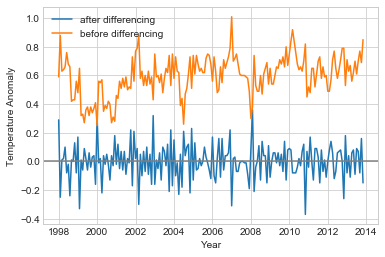

In [3]:
y_diff = monthly_df.iloc[:,0].diff().dropna()
time = [1998 + (i/12) for i in range(len(y_diff))]
plt.plot(time, y_diff, label = 'after differencing')
plt.plot(time, monthly_df.iloc[:-1,0], label = 'before differencing')
plt.ylabel('Temperature Anomaly')
plt.xlabel('Year')
plt.axhline(y = 0, color = 'gray')
plt.legend(loc='upper left')
plt.savefig('/Users/eddieshiang/climate_boot/pic3.png', dpi= 300)
plt.show()

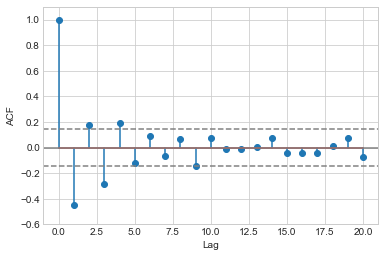

In [4]:
n = len(y_diff)
acf_vals = sm.tsa.acf(y_diff, nlags = lags)
plt.ylim(-0.6, 1.1)
plt.stem(list(range(lags + 1)), acf_vals)
plt.axhline(y=0,linestyle='-',color='gray')
plt.axhline(y=-1.96/np.sqrt(n),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(n),linestyle='--',color='gray')
plt.ylabel('ACF')
plt.xlabel('Lag')
plt.savefig('/Users/eddieshiang/climate_boot/pic4.png', dpi= 300)
plt.show()

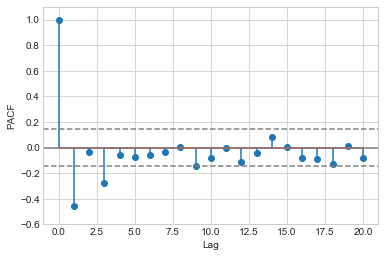

In [5]:
pacf_vals = sm.tsa.pacf(y_diff, nlags = lags)
plt.ylim(-0.6, 1.1)
plt.stem(list(range(lags + 1)), pacf_vals)
plt.axhline(y=0,linestyle='-',color='gray')
plt.axhline(y=-1.96/np.sqrt(n),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(n),linestyle='--',color='gray')
plt.ylabel('PACF')
plt.xlabel('Lag')
plt.savefig('/Users/eddieshiang/climate_boot/pic5.png', dpi= 300)
plt.show()

In [6]:
time = [1998 + (i/12) for i in range(monthly_df.shape[0])]

In [7]:
from statsmodels.tsa.arima_model import ARIMA

year_index = pd.date_range(start = '1998', end = '2014', freq = 'M')
final_df = monthly_df.set_index(year_index)

In [8]:
ma_model = ARIMA(final_df, order = (0, 1, 1))
ma_model_fit = ma_model.fit(disp = 0)
ma_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.change   No. Observations:                  191
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 154.278
Method:                       css-mle   S.D. of innovations              0.108
Date:                Tue, 17 Dec 2019   AIC                           -302.556
Time:                        00:14:37   BIC                           -292.799
Sample:                    02-28-1998   HQIC                          -298.604
                         - 12-31-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0003      0.003      0.091      0.928      -0.006       0.007
ma.L1.D.change    -0.5614      0.069     -8.106      0.000      -0.697      -0.426
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.7811           +0.0000j            1.7811            0.0000
-----------------------------------------------------------------------------
"""

In [9]:
all_mas = [ARIMA(final_df, order = (0, 1, i + 1)).fit(disp = 0).aic for i in range(3)]
all_ars = [ARIMA(final_df, order = (i + 1, 1, 0)).fit(disp = 0).aic for i in range(3)]
all_arimas = [ARIMA(final_df, order = (i, 1, i)).fit(disp = 0).aic for i in range(3)]

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

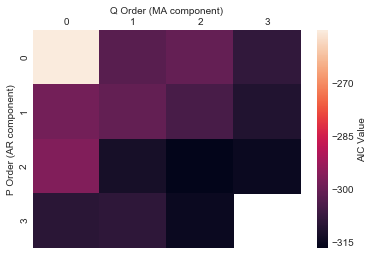

In [10]:
import seaborn as sns
aic = [[ARIMA(final_df, order = (p, 1, q)).fit(disp = 0).aic \
  if p + q != 6 else np.nan for q in range(4)] for p in range(4)]
ax = sns.heatmap(aic, cbar_kws={'label': 'AIC Value'})
ax.xaxis.tick_top()
plt.ylabel('P Order (AR component)')
plt.xlabel('Q Order (MA component)')
ax.xaxis.set_label_position('top') 
#plt.savefig('/Users/eddieshiang/climate_boot/pic6.png', dpi=1200)
plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

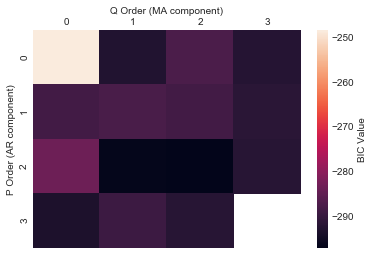

In [11]:
import seaborn as sns
bic = [[ARIMA(final_df, order = (p, 1, q)).fit(disp = 0).bic \
  if p + q != 6 else np.nan for q in range(4)] for p in range(4)]
ax = sns.heatmap(bic, cbar_kws={'label': 'BIC Value'})
ax.xaxis.tick_top()
plt.ylabel('P Order (AR component)')
plt.xlabel('Q Order (MA component)')
ax.xaxis.set_label_position('top') 

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

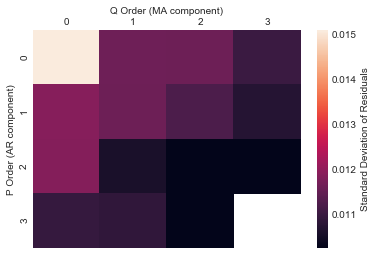

In [12]:
import seaborn as sns
sigma2 = [[ARIMA(final_df, order = (p, 1, q)).fit(disp = 0).sigma2 \
  if p + q != 6 else np.nan for q in range(4)] for p in range(4)]
ax = sns.heatmap(sigma2, cbar_kws={'label': 'Standard Deviation of Residuals'})
ax.xaxis.tick_top()
plt.ylabel('P Order (AR component)')
plt.xlabel('Q Order (MA component)')
ax.xaxis.set_label_position('top') 

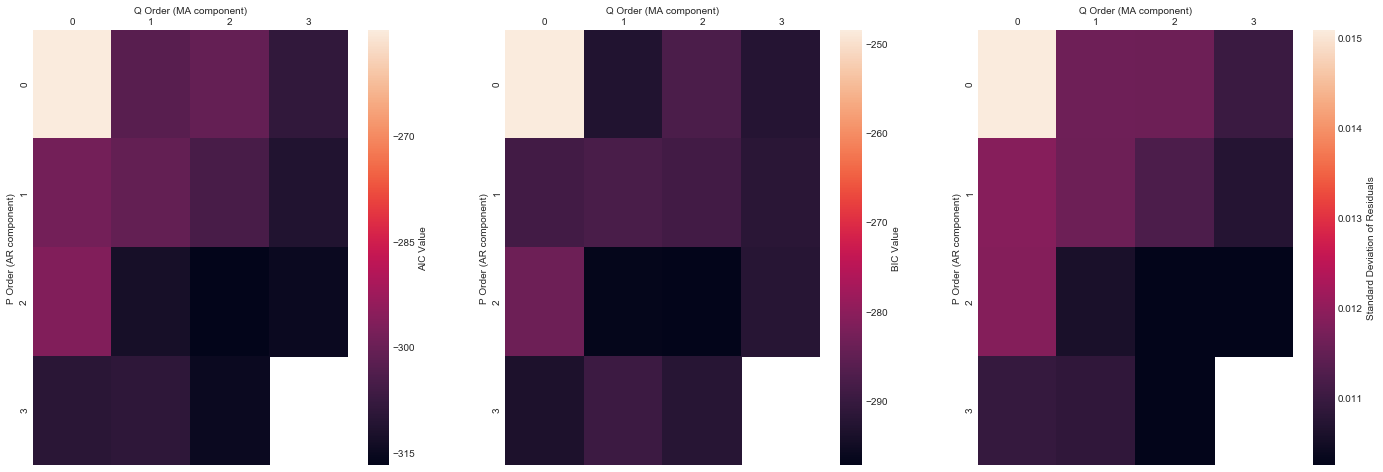

In [13]:
fig = plt.figure(figsize = [24, 8])

plt.subplot(1, 3, 1)
ax = sns.heatmap(aic, cbar_kws={'label': 'AIC Value'})
ax.xaxis.tick_top()
plt.ylabel('P Order (AR component)')
plt.xlabel('Q Order (MA component)')
ax.xaxis.set_label_position('top') 

plt.subplot(1, 3, 2)
ax = sns.heatmap(bic, cbar_kws={'label': 'BIC Value'})
ax.xaxis.tick_top()
plt.ylabel('P Order (AR component)')
plt.xlabel('Q Order (MA component)')
ax.xaxis.set_label_position('top') 

plt.subplot(1, 3, 3)
ax = sns.heatmap(sigma2, cbar_kws={'label': 'Standard Deviation of Residuals'})
ax.xaxis.tick_top()
plt.ylabel('P Order (AR component)')
plt.xlabel('Q Order (MA component)')
ax.xaxis.set_label_position('top') 
plt.savefig('/Users/eddieshiang/climate_boot/pic6.png', dpi= 300)
plt.show()

In [14]:
final_model = ARIMA(final_df, order = (0, 1, 1))
final_model_fit = final_model.fit(disp = 0)
final_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.change   No. Observations:                  191
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 154.278
Method:                       css-mle   S.D. of innovations              0.108
Date:                Tue, 17 Dec 2019   AIC                           -302.556
Time:                        00:14:46   BIC                           -292.799
Sample:                    02-28-1998   HQIC                          -298.604
                         - 12-31-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0003      0.003      0.091      0.928      -0.006       0.007
ma.L1.D.change    -0.5614      0.069     -8.106      0.000      -0.697      -0.426
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.7811           +0.0000j            1.7811            0.0000
-----------------------------------------------------------------------------
"""

In [15]:
predictions = final_model_fit.resid.reset_index(drop = True) + \
                pd.Series(final_df.iloc[1:,0].reset_index(drop = True))

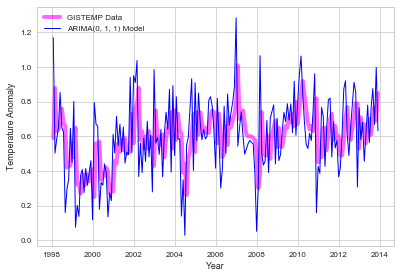

In [16]:
time = [1998 + ((i + 1)/12) for i in range(len(y_diff))]
plt.style.use('seaborn-paper')
plt.plot(time, monthly_df.iloc[:-1,0],  \
         label = 'GISTEMP Data', color = 'fuchsia', linewidth = 4, alpha = 0.6)
plt.plot(time, predictions, label = 'ARIMA(0, 1, 1) Model', \
         color = 'blue', linewidth = 1)
plt.ylabel('Temperature Anomaly')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.savefig('/Users/eddieshiang/climate_boot/pic8.png', dpi= 300)
plt.show()

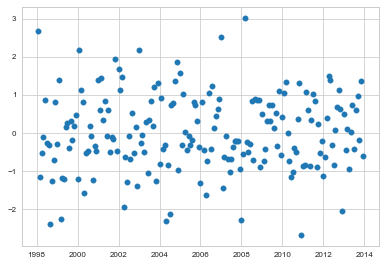

In [17]:
std_resid = final_model_fit.resid / np.std(final_model_fit.resid)
plt.scatter(time, std_resid)


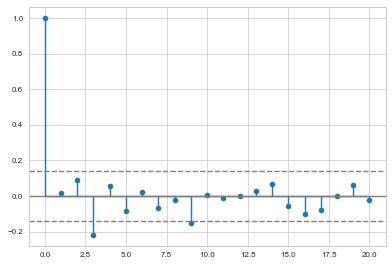

In [18]:
n = 20
acf_vals = sm.tsa.acf(final_model_fit.resid, nlags = n)
plt.stem(list(range(n + 1)), acf_vals)
plt.axhline(y=0,linestyle='-',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(final_model_fit.resid)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(final_model_fit.resid)),linestyle='--',color='gray')


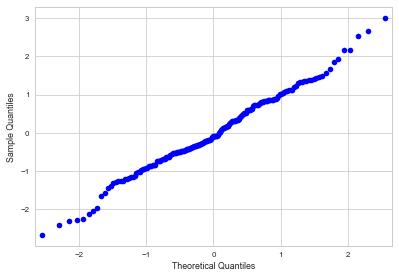

In [19]:
fig = sm.qqplot(std_resid)
plt.show()

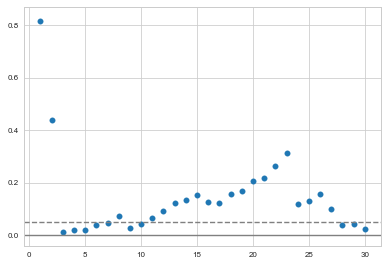

In [20]:
p_vals = sm.stats.acorr_ljungbox(std_resid, \
                        lags=[i + 1 for i in list(range(30))])[1]
plt.scatter([i + 1 for i in list(range(30))], p_vals)
plt.axhline(y=0.05, color='gray', linestyle = 'dashed')
plt.axhline(y=0.0, color='gray')

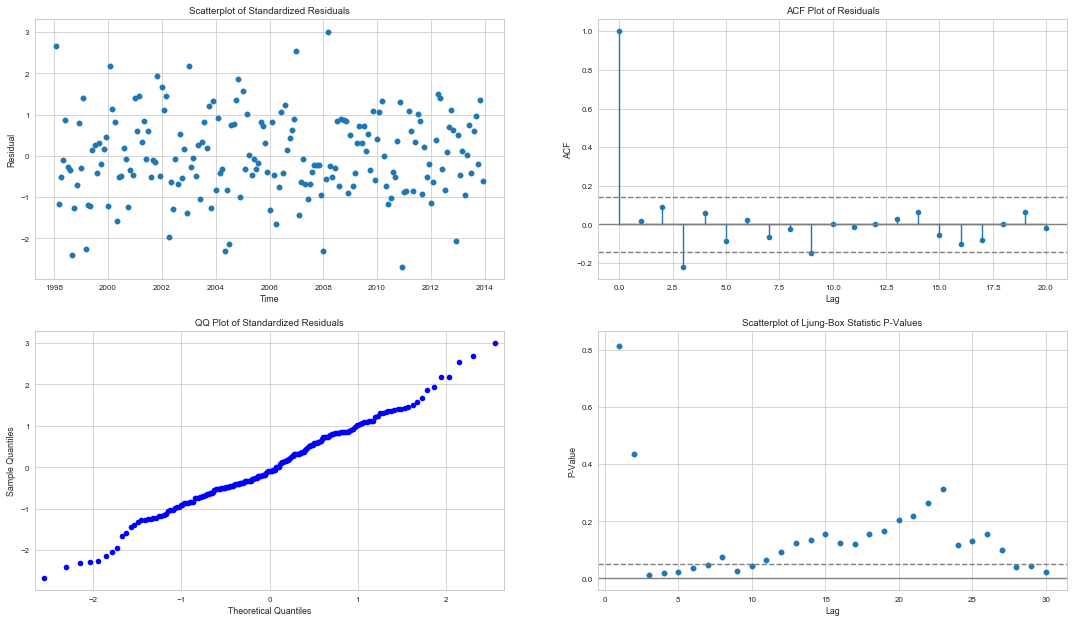

In [21]:


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(18.5, 10.5)

ax1.scatter(time, std_resid)
ax1.title.set_text('Scatterplot of Standardized Residuals')
ax1.set(xlabel = 'Time', ylabel = 'Residual')

ax2.stem(list(range(n + 1)), acf_vals)
ax2.axhline(y=0,linestyle='-',color='gray')
ax2.axhline(y=-1.96/np.sqrt(len(final_model_fit.resid)),linestyle='--',color='gray')
ax2.axhline(y=1.96/np.sqrt(len(final_model_fit.resid)),linestyle='--',color='gray')
ax2.title.set_text('ACF Plot of Residuals')
ax2.set(xlabel = 'Lag', ylabel = 'ACF')

sm.qqplot(std_resid, ax = ax3)
ax3.title.set_text('QQ Plot of Standardized Residuals')

ax4.scatter([i + 1 for i in list(range(30))], p_vals)
ax4.axhline(y=0.05, color='gray', linestyle = 'dashed')
ax4.axhline(y=0.0, color='gray')
ax4.title.set_text('Scatterplot of Ljung-Box Statistic P-Values')
ax4.set(xlabel = 'Lag', ylabel = 'P-Value')

plt.savefig('/Users/eddieshiang/climate_boot/pic9.png', dpi= 300)

        
plt.show()